In [12]:
import spkit as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import mne
from copy import deepcopy
from mne.preprocessing import compute_proj_ecg
from mne_connectivity import envelope_correlation
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import random
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
import autoreject
from autoreject import AutoReject
from autoreject import get_rejection_threshold
from autoreject import Ransac
from mne.preprocessing import annotate_amplitude


In [13]:
def Load_Raw(path, sfreq = 300, plot_raw = False):
    data = np.array(pd.read_csv(path, skiprows=2))

    data = np.delete(data, [0, 1, -1, -3, -4], axis=1)
    #data = np.delete(data, [0, 1, -1], axis=1)


    #ch_name = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'T2', 'T1', 'ECG']
    channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'ECG']
    #ch_name = ['F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'T2', 'T1']

    X = deepcopy(data)
    X = deepcopy(X[10000:-10000])

    sfreq = 300
    info = mne.create_info(channel_names, sfreq, ch_types=['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'ecg'])
    raw = mne.io.RawArray(X.T, info);
    raw.set_montage('standard_1020')

    if(plot_raw):
        raw.plot(scalings='auto');

    return raw


In [14]:
path = r"D:\Clean Data\IGE\shirband\samples.csv"
#Load_Raw(path);

In [15]:

name = 'KeshavarziSakine'


In [16]:
#mne.set_config("MNE_USE_CUDA", True)
#print(mne.get_config("MNE_USE_CUDA"))
print(mne.get_config("MNE_USE_CUDA"))

True


In [17]:

data = np.array(pd.read_csv(r"D:\Clean Data\TLE\KeshavarziSakine\samples.csv", skiprows=2))


data = np.delete(data, [0, 1, -1, -3, -4], axis=1)
#data = np.delete(data, [0, 1, -1], axis=1)

In [18]:
#ch_name = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'T2', 'T1', 'ECG']
channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'ECG']
#ch_name = ['F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'T2', 'T1']


In [19]:
np.shape(data)

(1811246, 22)

In [20]:
X = deepcopy(data)
X = deepcopy(X[10000:-10000])

In [21]:
sfreq = 300
info = mne.create_info(channel_names, sfreq, ch_types=['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'ecg'])
raw = mne.io.RawArray(X.T, info)
raw.set_montage('standard_1020')

Creating RawArray with float64 data, n_channels=22, n_times=1791246
    Range : 0 ... 1791245 =      0.000 ...  5970.817 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,24 points
Good channels,"21 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,ECG
Sampling frequency,300.00 Hz
Highpass,0.00 Hz
Lowpass,150.00 Hz


Using matplotlib as 2D backend.


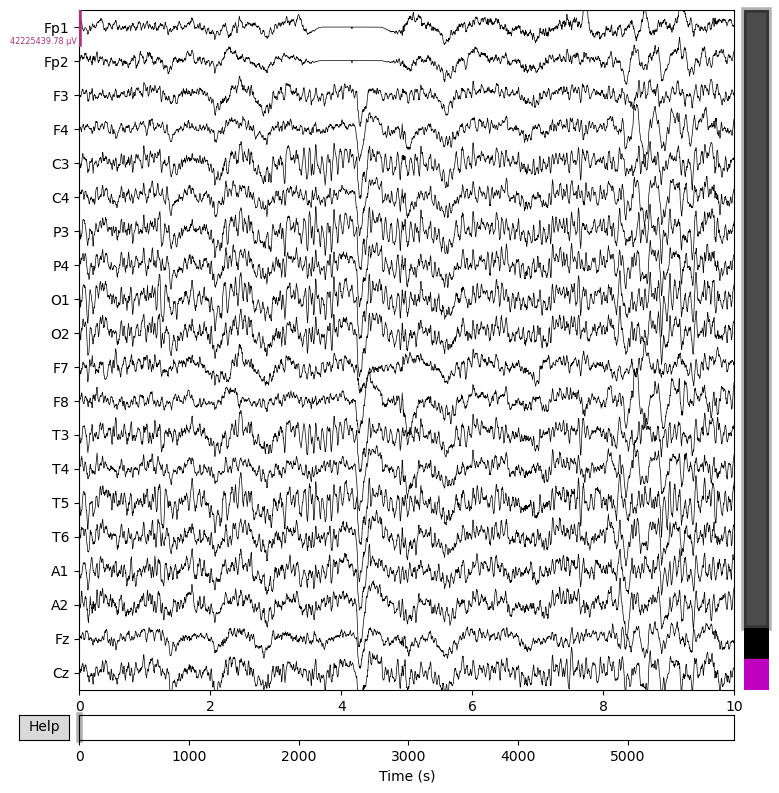

In [22]:
raw.plot(scalings='auto');

Fitting ICA to data using 21 channels (please be patient, this may take a while)


C:\Users\admin\AppData\Local\Temp\ipykernel_3592\3617974755.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.


Selecting by number: 21 components
Fitting ICA took 51.7s.
Fraction of eeg variance explained by all components: 1.0
Creating RawArray with float64 data, n_channels=22, n_times=1791246
    Range : 0 ... 1791245 =      0.000 ...  5970.817 secs
Ready.


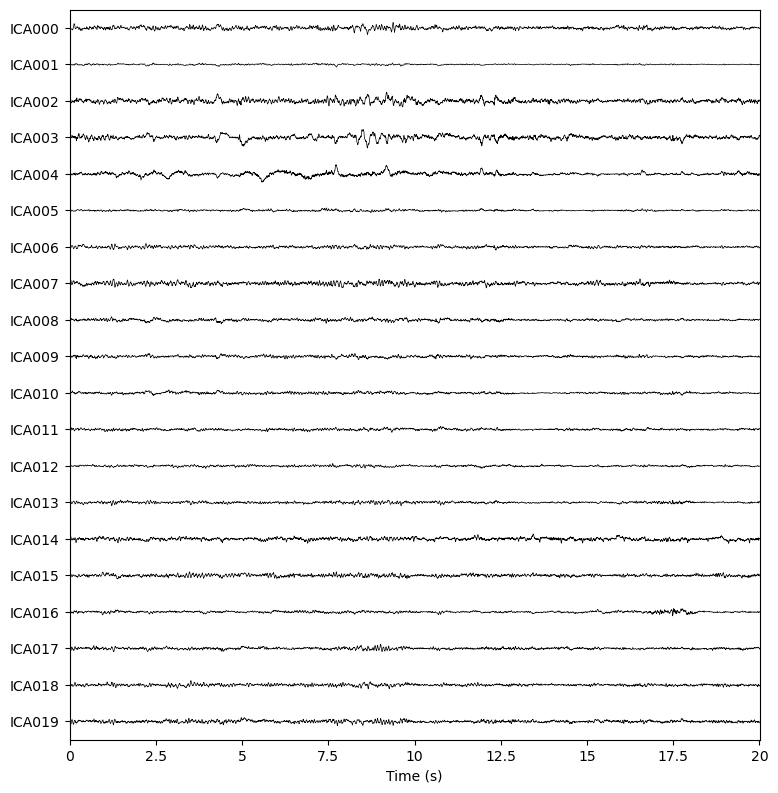

In [23]:
ica = ICA(n_components=21, max_iter="auto", random_state=97)
ica.fit(raw)

explained_var_ratio = ica.get_explained_variance_ratio(raw)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

raw.load_data()
ica.plot_sources(raw, show_scrollbars=False);

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 3000 samples (10.000 s)

Number of ECG events detected : 8047 (average pulse 80 / min.)
Not setting metadata
8047 matching events found
No baseline correction applied
Using data from preloaded Raw for 8047 events and 181 original time points ...
1 bad epochs dropped
Found 1 ECG component(s)


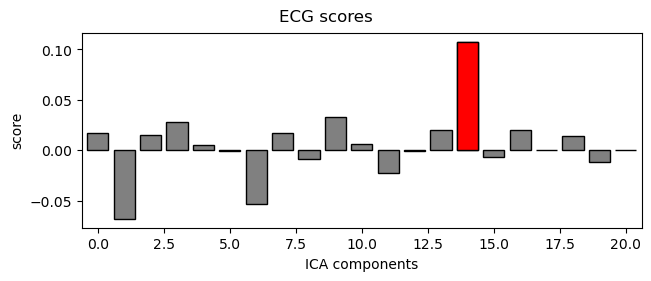

In [24]:
n_max_ecg = 15  
ecg_epochs = create_ecg_epochs(raw, tmin=-.3, tmax=.3)
#ecg_epochs.decimate(5).apply_baseline((None, None))
ecg_inds, scores_ecg = ica.find_bads_ecg(ecg_epochs, threshold='auto', method='correlation')
print('Found %d ECG component(s)' % (len(ecg_inds),))
ica.exclude += ecg_inds[:n_max_ecg]
ica.plot_scores(scores_ecg, exclude=ecg_inds, title='ECG scores');

In [25]:
print(ica.exclude)
ica.apply(raw, exclude=ica.exclude)

[14]
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 1 ICA component
    Projecting back using 21 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,24 points
Good channels,"21 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,ECG
Sampling frequency,300.00 Hz
Highpass,0.00 Hz
Lowpass,150.00 Hz


In [26]:
bad_segments = annotate_amplitude(raw, peak=5, flat=0.5, min_duration=0.5)
raw.set_annotations(bad_segments[0])
bad_segments[0]

Finding segments below or above PTP threshold.


<Annotations | 398 segments: BAD_flat (398)>

In [27]:
epochs = mne.make_fixed_length_epochs(raw, duration=10, preload=True, overlap= 1)

Not setting metadata
663 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 663 events and 3000 original time points ...
157 bad epochs dropped


In [28]:
ar = AutoReject()
new_epochs = ar.fit_transform(epochs, random)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/506 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/506 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/506 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/506 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/506 [00:00<?,       ?it/s]

Dropped 20 epochs: 12, 13, 32, 61, 62, 67, 69, 106, 116, 154, 177, 179, 199, 208, 224, 266, 281, 284, 397, 469


In [29]:
data = new_epochs[0].get_data()

C:\Users\admin\AppData\Local\Temp\ipykernel_3592\1220243084.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning


In [30]:
anode = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6']
cathode = ['F3', 'F8', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']
bipolar_data = mne.set_bipolar_reference(new_epochs[0], anode, cathode)


EEG channel type selected for re-referencing
Not setting metadata
486 matching events found
No baseline correction applied
0 projection items activated
Added the following bipolar channels:
Fp1-F3, Fp2-F8, F3-C3, F4-C4, C3-P3, C4-P4, P3-O1, P4-O2, F7-T3, F8-T4, T3-T5, T4-T6, T5-O1, T6-O2


In [31]:
bipolar_data.save(name + ".fif", overwrite=True)
bipolar_data_from_file = mne.read_epochs("saved-epochs-test.fif", preload=False)

C:\Users\admin\AppData\Local\Temp\ipykernel_3592\190183870.py:1: RuntimeWarning: This filename (KeshavarziSakine.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz


Reading d:\MNE Data\IGE\saved-epochs-test.fif ...
    Found the data of interest:
        t =       0.00 ...    9996.67 ms
        0 CTF compensation matrices available
Not setting metadata
588 matching events found
No baseline correction applied
0 projection items activated


C:\Users\admin\AppData\Local\Temp\ipykernel_3592\190183870.py:2: RuntimeWarning: This filename (saved-epochs-test.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz


In [32]:
data.max()

273.62533307014945